# Dask through Jupyter Notebooks

This notebook runs a simple study on SUEP data using Dask, creating an output coffea file that can be analyzed in Dask_analysis.ipynb.

In [1]:
import os
import sys
import json
import time
import random
import numpy as np
import fastjet
import awkward as ak
import vector
vector.register_awkward()
import coffea
coffea.deprecations_as_errors = False #Get rid of warning for now
from coffea import hist, processor
from hist import Hist
import matplotlib

sys.path.append("..")
from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report
from workflows.SUEP_coffea import SUEP_cluster
#from plotting.plot_utils import *

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

We set up a coffea ABC Processor to analyze the ROOT files.

In [3]:
class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str, scouting: int) -> None:
        
#         import os
#         import sys
#         import json
#         import time
#         import random
#         import numpy as np
#         import fastjet
#         import awkward as ak
#         import vector
#         vector.register_awkward()

#         sys.path.append("..")
#         from workflows.math_utils import sphericity
        
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample
        self.scouting = scouting

        self._accumulator = processor.dict_accumulator(
            {
                # cutflows
                "sumw": processor.defaultdict_accumulator(float),
                "total": processor.defaultdict_accumulator(float),
                "cut1": processor.defaultdict_accumulator(float),
                "cut2": processor.defaultdict_accumulator(float),
                "cut3": processor.defaultdict_accumulator(float),
                "cut4": processor.defaultdict_accumulator(float),
                "cut5": processor.defaultdict_accumulator(float),
                
                # histograms
                "ht_ak4": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_ak4", r"$H_T$ [GeV]", 500,0,5000),
                ),
            }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def getak4jets(self, events):
        if self.scouting == 1:
            Jets = ak.zip({
                "pt": events.Jet.pt,
                "eta": events.Jet.eta,
                "phi": events.Jet.phi,
                "mass": events.Jet.mass,
            })
        else:
            Jets = ak.zip({
                "pt": events.Jet.pt,
                "eta": events.Jet.eta,
                "phi": events.Jet.phi,
                "mass": events.Jet.mass,
                "jetId": events.Jet.jetId
            })
        jetCut = (Jets.pt > 30) & (abs(Jets.eta)<2.4)
        ak4jets = Jets[jetCut]
        return ak4jets
    
    # this is modified from the normal SUEP_cluster one,
    # since we need to count events after each selection
    def eventSelection(self, events, output, dataset):
        
        ak4jets = self.getak4jets(events)
        
        ht = ak.sum(ak4jets.pt,axis=-1)
        output['ht_ak4'].fill(ht_ak4=ht, dataset=dataset)
        
        # apply trigger selection
        if self.scouting == 1:
            events = events[(ht > 600)]
            ak4jets = ak4jets[(ht > 600)]
        else:
            if self.era == 2016:
                trigger = events.HLT.PFHT900 == 1
            else:
                trigger = events.HLT.PFHT1050 == 1

            events = events[(trigger)]
            ak4jets = ak4jets[(trigger)]
            ht = ht[(trigger)]

            output["cut1"][dataset] += len(events)

            events = events[(ht > 1200)]
            ak4jets = ak4jets[(ht > 1200)]

            output["cut2"][dataset] += len(events)
            
        return events, ak4jets

    def process(self, events):
        output = self.accumulator
        dataset = events.metadata['dataset']
                
        # this needs to be here!
        # FIXME: why isn't doing this in __init__ enough?
        vector.register_awkward()

        if self.isMC: self.gensumweight = ak.sum(events.genWeight)
        
        output["sumw"][dataset] += ak.sum(events.genWeight)
        output["total"][dataset] += len(events)
        
        events, ak4jets = self.eventSelection(events, output, dataset)
    
        if len(events) == 0:
            return output
    
#         tracks, Cleaned_cands = SUEP_cluster.getTracks(self, events)
        
#         # events = events[ak.num(tracks) > 0]
#         # tracks = tracks[ak.num(tracks) > 0]
#         indices = np.arange(0,len(tracks))
        
#         if len(tracks) == 0:
#             return output
        
#         ak_inclusive_jets, ak_inclusive_cluster = SUEP_cluster.FastJetReclustering(self, tracks, r=1.5, minPt=150)
                
#         # remove events with at least 2 clusters (i.e. need at least SUEP and ISR jets for IRM)
#         clusterCut = (ak.num(ak_inclusive_jets, axis=1)>1)
#         ak_inclusive_cluster = ak_inclusive_cluster[clusterCut]
#         ak_inclusive_jets = ak_inclusive_jets[clusterCut]
#         tracks = tracks[clusterCut]
#         indices = indices[clusterCut]   
#         output['cut3'][dataset] += len(tracks)
        
#         if len(tracks) == 0:
#             return output
        
#         tracks, indices, topTwoJets = SUEP_cluster.getTopTwoJets(self, tracks, indices, ak_inclusive_jets, ak_inclusive_cluster)
#         SUEP_cand, ISR_cand, SUEP_cluster_tracks, ISR_cluster_tracks = topTwoJets
        
#         # boost into frame of SUEP
#         boost_SUEP = ak.zip({
#             "px": SUEP_cand.px*-1,
#             "py": SUEP_cand.py*-1,
#             "pz": SUEP_cand.pz*-1,
#             "mass": SUEP_cand.mass
#         }, with_name="Momentum4D")        
        
#         # SUEP tracks for this method are defined to be the ones from the cluster
#         # that was picked to be the SUEP jet
#         SUEP_tracks_b = SUEP_cluster_tracks.boost_p4(boost_SUEP)        
        
#         # SUEP jet variables
#         eigs = sphericity(SUEP_tracks_b,1.0) #Set r=1.0 for IRC safe
#         S1 = 1.5 * (eigs[:,1]+eigs[:,0])
#         nconst = ak.num(SUEP_tracks_b)
        
#         tracks = tracks[(nconst > 80)]
#         S1 = S1[(nconst > 80)]
#         output['cut4'][dataset] += len(tracks)
        
#         tracks = tracks[(S1 > 0.5)]
#         output['cut5'][dataset] += len(tracks)
                
        return output
        
    def postprocess(self, accumulator):
        return accumulator

The following section defines additional parts of the slurm Dask job. Here we source the bashrc to prepare Conda. We also pass in the x509 proxy. In order to share the proxy across the SubMIT machines you should move your proxy to your HOME directory.

In [4]:
slurm_env = [
     'export XRD_RUNFORKHANDLER=1',
     'export XRD_STREAMTIMEOUT=10',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate SUEP',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u210253',
     'export PYTHONPATH=/home/submit/lavezzo/SUEP/SUEPCoffea_dask/:/home/submit/lavezzo/SUEP/SUEPCoffea_dask/workflows/:$PYTHONPATH'
     # 'sleep $[ ( $RANDOM % 1000 )  + 1 ]s'
]

extra_args=[
     "--output=logs/dask_job_output_%j.out",
     "--error=logs/dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

In [5]:
n_port       = 6820                   # might need to change this if re running
w_port       = 9765
cores        = 1
processes    = 1
memory       = "1 GB"

The following sets up the processor and json file. If you want to change files you can simply modify the json file

In [6]:
# load samples
file = "../filelist/list_2018_SUEP_A01.txt"
samples = []
with open(file, 'r') as stream:
    for sample in stream.read().split('\n'):
        if '#' in sample: continue
        if len(sample.split('/')) <= 1: continue
        sample_name = sample.split("/")[-1]
        samples.append(sample_name)
        
file = "../filelist/list_2018_HT_A01.txt"
with open(file, 'r') as stream:
    for sample in stream.read().split('\n'):
        if '#' in sample: continue
        if len(sample.split('/')) <= 1: continue
        sample_name = sample.split("/")[-1]
        samples.append(sample_name)

In [7]:
# load file names
samples_dict = {}
for sample_name in samples:
    
    
    input_list = "/home/tier3/cmsprod/catalog/t2mit/nanosu/A01/{}/RawFiles.00".format(sample_name)
    
    files = []
    Raw_list = open(input_list, "r")
    for i in Raw_list:
        file = i.split(" ")[0]
        files.append(file)
    
    samples_dict[sample_name] = files
process_dict = samples_dict

In [8]:
from plotting import fill_utils
# cross section
xsections = {}
for sample in list(process_dict.keys()):
    if 'SUEP' in sample: 
        xsection = fill_utils.getXSection(sample.split('-m')[1].split('-')[0], '2018', SUEP=True)
    else: xsection = fill_utils.getXSection(sample, '2018', SUEP=False)
    xsections.update({sample.split('+')[0]:xsection})

The next section forms the Slurm Cluster. You can set up various parameters of the cluster here.

In [9]:
while not check_port(n_port):
    time.sleep(5)
    n_port+=1

import socket
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=cores,
        processes=processes,
        memory=memory,
        #retries=10,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 22378,
              'host': socket.gethostname()
        },
    
        job_extra=extra_args,
        env_extra=slurm_env,
)

In [10]:
cluster.adapt(minimum=1, maximum=250)
client = Client(cluster)
print(client)

<Client: 'tcp://18.12.2.2:6820' processes=0 threads=0, memory=0 B>


## Running the processor
Now we will run the code with a performance report. This will analyze all of the input ROOT files and will store the histograms in output. Then we can analyze the output and make plots.

In [10]:
# Form a run dict of files you want to process
run_dict = {}

# SUEP
template = 'SUEP-m{}-{}+RunIIAutumn18-private+MINIAODSIM'
for m in ['125', '400', '750', '1000']:
    decay = 'generic'
    #if m == '125': decay+="-htcut"
    key = template.format(m, decay)
    new_key = key.split('+')[0]
    print(len(process_dict[key]))
    run_dict.update({new_key:process_dict[key][:100]})
    
# QCD
percent = 0.1
for sample in samples:
    if 'QCD_HT' not in sample: continue
    new_key = sample.split('QCD_HT')[1].split("_Tune")[0]
    QCD_bin = samples_dict[sample]
    nfiles = int(percent * len(QCD_bin))
    print(nfiles)
    #run_dict.update({new_key:QCD_bin[:nfiles]})

99
99
100
100
32
92
22
11
115
132
103
43


In [15]:
processor_instance = Simple_Process(isMC=1, era='2018', sample='test', scouting=0)
with performance_report(filename="dask-report.html"):
    output = processor.run_uproot_job(run_dict,
             treename='Events',
             processor_instance=processor_instance,
             executor=processor.dask_executor,
             executor_args={
                           'client': client,
                           'skipbadfiles': True,
                           'schema': processor.NanoAODSchema,
                           'xrootdtimeout': 30,
                            'retries': 5,
                           },
             chunksize=100000)
coffea.util.save(output, "unscaled_SUEP_cutflows.coffea")

[                                        ] | 0% Completed |  0.5s

Task exception was never retrieved
future: <Task finished name='Task-10782' coro=<_wrap_awaitable() done, defined at /work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/asyncio/tasks.py:681> exception=RuntimeError('Command exited with non-zero exit code.\nExit code: -2\nCommand:\nsbatch /tmp/tmphnw6lhha.sh\nstdout:\n\nstderr:\n\n')>
Traceback (most recent call last):
  File "/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/asyncio/tasks.py", line 688, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/distributed/deploy/spec.py", line 59, in _
    await self.start()
  File "/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py", line 335, in start
    out = await self._submit_job(fn)
  File "/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py", line 318, in _submit_job
    return self._call(shlex.split(self.

KeyboardInterrupt: 

In [16]:
client.cancel(cluster)

In [12]:
processor_instance = Simple_Process(isMC=1, era='2018', sample='test', scouting=0)
output = processor.run_uproot_job(run_dict,
             treename='Events',
             processor_instance=processor_instance,
             executor=processor.futures_executor,
             executor_args={
                           'workers': 20,
                           'skipbadfiles': True,
                           'schema': processor.NanoAODSchema,
                           'xrootdtimeout': 100,
                           },
             chunksize=100000)
coffea.util.save(output, "unscaled_SUEP_cutflows.coffea")

Processing 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398/398 [ 0:01:15 < 0:00:00 | 5.8  chunk/s ]
Merging (local) 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398/398 [ 0:01:15 < 0:00:00 | ?   merges/s ]

In [18]:
output = coffea.util.load("unscaled_SUEP_cutflows.coffea")
output

{'sumw': defaultdict_accumulator(float,
                         {'SUEP-m1000-generic': 10006.311653137207,
                          'SUEP-m750-generic': 9997.6450881958,
                          'SUEP-m400-generic': 9898.887825012207,
                          'SUEP-m125-generic': 9899.140037536621}),
 'total': defaultdict_accumulator(float,
                         {'SUEP-m1000-generic': 10000.0,
                          'SUEP-m750-generic': 10000.0,
                          'SUEP-m400-generic': 9900.0,
                          'SUEP-m125-generic': 9900.0}),
 'cut1': defaultdict_accumulator(float,
                         {'SUEP-m1000-generic': 354.0,
                          'SUEP-m750-generic': 252.0,
                          'SUEP-m400-generic': 111.0,
                          'SUEP-m125-generic': 13.0}),
 'cut2': defaultdict_accumulator(float,
                         {'SUEP-m1000-generic': 301.0,
                          'SUEP-m750-generic': 206.0,
                     

In [14]:
xsections

{'SUEP-m1000-darkPhoHad': 0.17,
 'SUEP-m1000-darkPho': 0.17,
 'SUEP-m1000-generic': 0.17,
 'SUEP-m125-darkPhoHad': 34.8,
 'SUEP-m125-darkPho': 34.8,
 'SUEP-m125-generic': 34.8,
 'SUEP-m125-generic-htcut': 34.8,
 'SUEP-m400-darkPhoHad': 5.9,
 'SUEP-m400-darkPho': 5.9,
 'SUEP-m400-generic': 5.9,
 'SUEP-m750-darkPhoHad': 0.5,
 'SUEP-m750-darkPho': 0.5,
 'SUEP-m750-generic': 0.5,
 'SUEP-m400-md2-t0.5-generic': 5.9,
 'SUEP-m400-md2-t1-generic': 5.9,
 'SUEP-m400-md2-t2-generic': 5.9,
 'SUEP-m400-md2-t3-generic': 5.9,
 'SUEP-m400-md2-t4-generic': 5.9,
 'SUEP-m400-md3-t1.5-generic': 5.9,
 'SUEP-m400-md3-t3-generic': 5.9,
 'SUEP-m400-md3-t6-generic': 5.9,
 'SUEP-m400-md5-t10-generic': 5.9,
 'SUEP-m400-md5-t1-generic': 5.9,
 'SUEP-m400-md5-t5-generic': 5.9,
 'QCD_HT1000to1500_TuneCP5_PSWeights_13TeV-madgraph-pythia8': 1127.0,
 'QCD_HT100to200_TuneCP5_PSWeights_13TeV-madgraph-pythia8': 23590000.0,
 'QCD_HT1500to2000_TuneCP5_PSWeights_13TeV-madgraph-pythia8': 109.8,
 'QCD_HT2000toInf_TuneCP5_PSWei

In [16]:
# calculate normalization
scales = {} 
for dataset in output["sumw"]:
    xsec = xsections[dataset]
    scale = xsec / output["sumw"][dataset]
    if 'htcut' in dataset: 
        scale *= 0.003
    scales.update({dataset: scale})
    
# apply normalization to all histograms and accumulators
for key in list(output.keys()):
    if key.lower() == 'sumw': continue
    print(key)
    if type(output[key]) == coffea.processor.accumulator.defaultdict_accumulator:
        for jkey in output[key].keys():
            if jkey not in scales: 
                print(jkey, 'not found')
                continue
            output[key][jkey] *= scales[jkey]
            
    else:
        output[key].scale(scales, axis='dataset')

coffea.util.save(output, "SUEP_cutflows.coffea")

total
cut1
cut2
cut3
cut4
cut5
ht_ak4


/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encounter

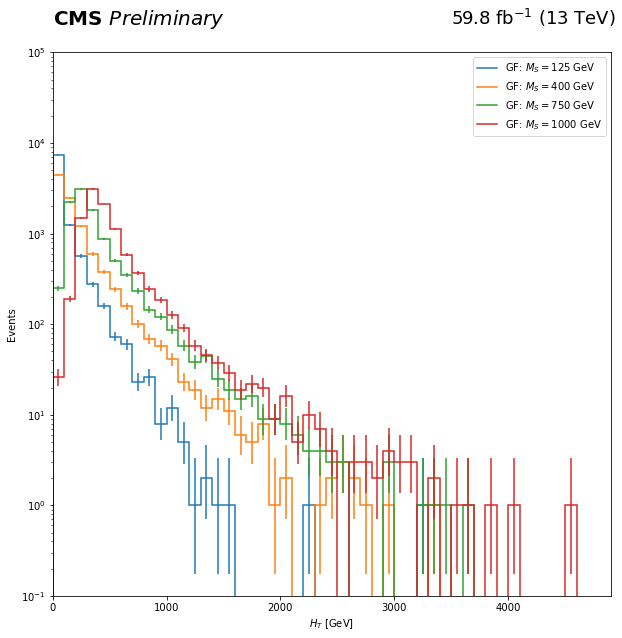

In [29]:
import matplotlib.pyplot as plt
from coffea.hist import plot
import mplhep as hep

h_ht = output['ht_ak4']

bins = []
bins= np.append(bins, np.arange(0,5000,100))
#print(bins)

h2 = h_ht.rebin("ht_ak4", hist.Bin("ht_ak4", r"$H_T$ [GeV]", bins))

fig = plt.figure(figsize=(10,10))
ax = fig.subplots()
labels = [r"GF: $M_{S}=125$ GeV",r"GF: $M_{S}=400$ GeV",r"GF: $M_{S}=750$ GeV",r"GF: $M_{S}=1000$ GeV"]
#plot.plot1d(output['ht_ak4']["SUEP-m1000-generic"], ax=ax, clear=False, density=True)

plot.plot1d(h2, ax=ax, density=False, 
            order=['SUEP-m125-generic','SUEP-m400-generic',
                   'SUEP-m750-generic', 'SUEP-m1000-generic'])
cms = ax.text(
        -0.05, 2e5, u"CMS $\it{Preliminary}$",
        fontsize=20, fontweight='bold',
)
lumi = ax.text(
    3500, 2e5, r"%.1f fb$^{-1}$ (13 TeV)" % 59.8,
    fontsize=18, 
)
_ = ax.set_yscale('log')
_ = ax.set_ylim(1e-1, 1e5)
_ = ax.set_ylabel("Events")
_ = ax.legend(title=None, labels=labels)

plt.savefig("nocut_HT_2018.pdf")